In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import VGG16

2024-06-22 21:14:44.617317: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-22 21:14:44.684790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 21:14:45.940824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
import zipfile

def extract_and_count_files(zip_file_path, extracted_folder_path):
    # Tworzenie katalogów train, test, valid oraz ich podkatalogów painting i photos
    for folder in ['train', 'test', 'valid']:
        os.makedirs(os.path.join(extracted_folder_path, folder, 'painting'), exist_ok=True)
        os.makedirs(os.path.join(extracted_folder_path, folder, 'photos'), exist_ok=True)

    # Rozpakowanie archiwum zip do odpowiednich folderów
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder_path)

    # Inicjalizacja słownika, w którym będziemy przechowywać liczbę plików w każdym podkatalogu
    files_count = {'train': {'painting': 0, 'photos': 0},
                   'test': {'painting': 0, 'photos': 0},
                   'valid': {'painting': 0, 'photos': 0}}

    # Sprawdzenie ile plików jpg zostało w każdym z folderów
    for folder in ['train', 'test', 'valid']:
        painting_path = os.path.join(extracted_folder_path, folder, 'painting')
        photos_path = os.path.join(extracted_folder_path, folder, 'photos')
        num_painting_files = len([name for name in os.listdir(painting_path) if name.endswith('.jpg')])
        num_photos_files = len([name for name in os.listdir(photos_path) if name.endswith('.jpg')])
        files_count[folder]['painting'] = num_painting_files
        files_count[folder]['photos'] = num_photos_files

    return files_count

# Ścieżka do archiwum zip
zip_file_path = "painting-vs-photograph-classification-dataset.zip"

# Ścieżka do katalogu, do którego chcemy rozpakować dane
extracted_folder_path = "extracted_data"

# Wywołanie funkcji i wyświetlenie wyników
files_count = extract_and_count_files(zip_file_path, extracted_folder_path)
for folder in ['train', 'test', 'valid']:
    print(f"W folderze {folder}: {files_count[folder]['painting']} plików typu painting i {files_count[folder]['photos']} plików typu photos.")


W folderze train: 3513 plików typu painting i 3528 plików typu photos.
W folderze test: 0 plików typu painting i 0 plików typu photos.
W folderze valid: 1505 plików typu painting i 1505 plików typu photos.


In [3]:
# Ustawienia
train_dir = 'extracted_data/train'
valid_dir = 'extracted_data/valid'
batch_size = 32
img_height, img_width = 224, 224
num_epochs = 10
learning_rate = 0.0001

In [4]:
# Transformacje danych
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(img_height),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [5]:
# Przygotowanie danych
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
# Przygotowanie modelu
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Output: 1 neuron dla klasyfikacji binarnej

model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Definicja loss function oraz optymalizatora
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Trenowanie modelu
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu').float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(outputs) > 0.5
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')


Epoch 0/9, Loss: 0.3083, Accuracy: 0.8709
Epoch 1/9, Loss: 0.2155, Accuracy: 0.9100
Epoch 2/9, Loss: 0.1941, Accuracy: 0.9216
Epoch 3/9, Loss: 0.1795, Accuracy: 0.9290
Epoch 4/9, Loss: 0.1506, Accuracy: 0.9425
Epoch 5/9, Loss: 0.1566, Accuracy: 0.9416
Epoch 6/9, Loss: 0.1333, Accuracy: 0.9480
Epoch 7/9, Loss: 0.1223, Accuracy: 0.9541
Epoch 8/9, Loss: 0.1324, Accuracy: 0.9497
Epoch 9/9, Loss: 0.1090, Accuracy: 0.9590


In [8]:
# Ewaluacja modelu
model.eval()
running_corrects = 0

for inputs, labels in valid_loader:
    inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu').float().unsqueeze(1)

    with torch.no_grad():
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds == labels.data)

valid_acc = running_corrects.double() / len(valid_dataset)
print(f'Validation Accuracy: {valid_acc * 100:.2f}%')

Validation Accuracy: 93.73%


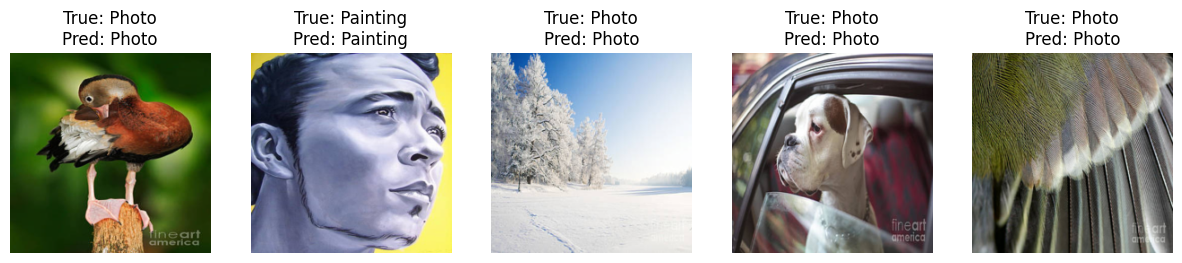

In [9]:

# Funkcja do wyświetlania przewidywań
def display_predictions(loader, model, num_images=5):
    model.eval()
    data_iter = iter(loader)
    
    # Pobierz obrazy i etykiety
    images, labels = next(data_iter)
    images, labels = images[:num_images], labels[:num_images]
    images, labels = images.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Przewidywania modelu
    with torch.no_grad():
        outputs = model(images)
    preds = torch.sigmoid(outputs) > 0.5
    
    # Ustawienia wyświetlania
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx in range(num_images):
        ax = axes[idx]
        img = images[idx].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        true_label = 'Photo' if labels[idx].item() == 1 else 'Painting'
        pred_label = 'Photo' if preds[idx].item() == 1 else 'Painting'
        
        ax.imshow(img)
        ax.set_title(f'True: {true_label}\nPred: {pred_label}')
        ax.axis('off')
    
    plt.show()

# Wywołanie funkcji display_predictions z odpowiednim modelem i loaderem
display_predictions(valid_loader, model, num_images=5)

VGG16

In [10]:
# Przygotowanie modelu VGG16
vgg16_weights = models.VGG16_Weights.IMAGENET1K_V1
vgg16_model = models.vgg16(weights=vgg16_weights)
num_ftrs_vgg = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Linear(num_ftrs_vgg, 1)  # Output: 1 neuron dla klasyfikacji binarnej

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vgg16_model = vgg16_model.to(device)

# Definicja funkcji straty i optymalizatora
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=learning_rate)


In [11]:
# Funkcja do przeprowadzania walidacji
def validate(model, criterion, valid_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.sigmoid(outputs) > 0.5
            correct += torch.sum(preds == labels.byte()).item()
    
    val_loss = val_loss / len(valid_dataset)
    accuracy = correct / len(valid_dataset)
    
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

In [12]:
# Trenowanie modelu
vgg16_model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = vgg16_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}', end=' ')
    
    # Wywołaj funkcję walidacji po każdej epoce
    validate(vgg16_model, criterion, valid_loader)

Epoch [1/10], Training Loss: 0.3734 Validation Loss: 0.2475, Accuracy: 89.85%
Epoch [2/10], Training Loss: 0.2797 Validation Loss: 0.3066, Accuracy: 89.42%
Epoch [3/10], Training Loss: 0.2955 Validation Loss: 0.2474, Accuracy: 90.05%
Epoch [4/10], Training Loss: 0.2366 Validation Loss: 0.1992, Accuracy: 92.17%
Epoch [5/10], Training Loss: 0.2166 Validation Loss: 0.1947, Accuracy: 93.10%
Epoch [6/10], Training Loss: 0.1973 Validation Loss: 0.1937, Accuracy: 93.07%
Epoch [7/10], Training Loss: 0.1879 Validation Loss: 0.2226, Accuracy: 91.34%
Epoch [8/10], Training Loss: 0.1675 Validation Loss: 0.1729, Accuracy: 94.16%
Epoch [9/10], Training Loss: 0.1679 Validation Loss: 0.1707, Accuracy: 93.33%
Epoch [10/10], Training Loss: 0.1551 Validation Loss: 0.1877, Accuracy: 93.03%


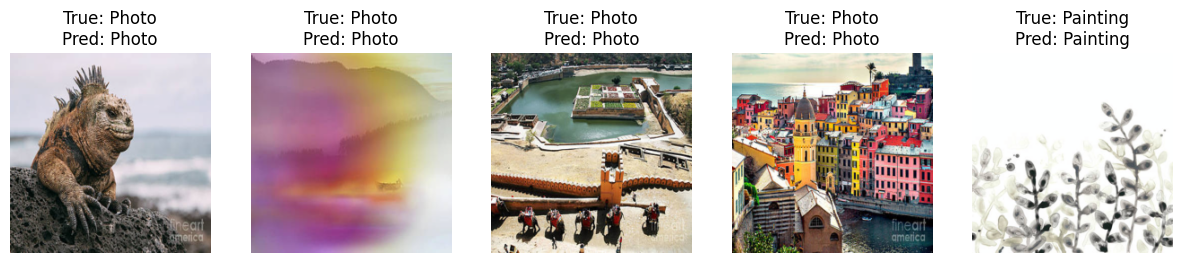

In [22]:
display_predictions(valid_loader, vgg16_model, num_images=5)